In [1]:
%matplotlib inline

In [2]:
from plotting import plotstuff
from imp import reload

In [3]:
'''This script demonstrates how to build a variational autoencoder with Keras.

Reference: "Auto-Encoding Variational Bayes" https://arxiv.org/abs/1312.6114
'''
import time
import numpy as np
import matplotlib.pyplot as plt

from keras.layers import Input, Dense, Lambda, Flatten, Reshape, BatchNormalization, Dropout, GaussianNoise, GaussianDropout, Activation
from keras.layers import Convolution2D, Deconvolution2D, MaxPooling2D
from keras.models import Model
from keras import backend as K_backend
from keras import objectives
from keras.datasets import mnist
from keras.utils import np_utils

Using TensorFlow backend.


In [4]:
from keras_tqdm import TQDMCallback, TQDMNotebookCallback

In [5]:
# global
nb_epoch = 50

class VariationalAutoencoder(object):
    def __init__(self, original_dim=784, latent_dim=2, intermediate_dim=256, batch_size=100, epsilon_std=1.0):
        #vae params
        self.batch_size = batch_size
        self.original_dim = original_dim
        self.latent_dim = latent_dim
        self.intermediate_dim = intermediate_dim
        self.epsilon_std = epsilon_std

        x = Input(batch_shape=(batch_size, original_dim), name='x_input')
        h = Dense(intermediate_dim, activation='relu', name='h_hidden_relu_1')(x)
        self.z_mean = Dense(latent_dim, name='Z_Mean')(h)
        self.z_log_var = Dense(latent_dim, name='Z_Log_Var')(h)

        # note that "output_shape" isn't necessary with the TensorFlow backend
        z = Lambda(self.sampling, output_shape=(latent_dim,))([self.z_mean, self.z_log_var])

        # we instantiate these layers separately so as to reuse them later
        decoder_h = Dense(intermediate_dim, activation='relu', name='Decoder_H_Relu')
        decoder_mean = Dense(original_dim, activation='sigmoid', name='Decoder_Mean_sig')
        h_decoded = decoder_h(z)
        x_decoded_mean = decoder_mean(h_decoded)


        self.model = Model(x, x_decoded_mean)
        self.model.compile(optimizer='rmsprop', loss=self.vae_loss)

        # build a model to project inputs on the latent space
        self.encoder = Model(x, self.z_mean)

        # build a digit generator that can sample from the learned distribution
        decoder_input = Input(shape=(latent_dim,))
        _h_decoded = decoder_h(decoder_input)
        _x_decoded_mean = decoder_mean(_h_decoded)
        self.generator = Model(decoder_input, _x_decoded_mean)


    def vae_loss(self, x, x_decoded_mean):
        xent_loss = self.original_dim * objectives.binary_crossentropy(x, x_decoded_mean)
        kl_loss = - 0.5 * K_backend.sum(1 + self.z_log_var - K_backend.square(self.z_mean) - K_backend.exp(self.z_log_var), axis=-1)
        return xent_loss + kl_loss


    def sampling(self, z_args):
        "Unpacks the tuple input and conducts probabilistic sampling"
        z_mean, z_log_var = z_args
        epsilon = K_backend.random_normal(shape=(self.batch_size, self.latent_dim), mean=0.,
                                  std=self.epsilon_std)
        return z_mean + K_backend.exp(z_log_var / 2) * epsilon

    def fit(self, x, y, batch_size=None, nb_epoch=10, verbose=1, callbacks=[], validation_split=0.,
            validation_data=None, shuffle=True, class_weight=None, sample_weight=None):
        callbacks_history = self.model.fit(x, y, batch_size, nb_epoch, verbose, callbacks, validation_split,
                                           validation_data, shuffle, class_weight, sample_weight)
        return callbacks_history


vaeclass = VariationalAutoencoder(latent_dim=2)
vae = vaeclass.model
encoder = vaeclass.encoder
generator = vaeclass.generator

In [6]:
# ==== dataset handling - train the VAE on MNIST digits ===
batch_size = 100
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))


In [7]:
import keras.utils.visualize_util
keras.utils.visualize_util.plot(vae, 'vae.png', show_shapes=True)
plt.show()

In [8]:
# assert 0, 'pause'
vae.fit(x_train, x_train,
        shuffle=True,
        nb_epoch=1,
        batch_size=batch_size,
        validation_data=(x_test, x_test),
        verbose=False, callbacks=[TQDMNotebookCallback()])

(10000, 2)


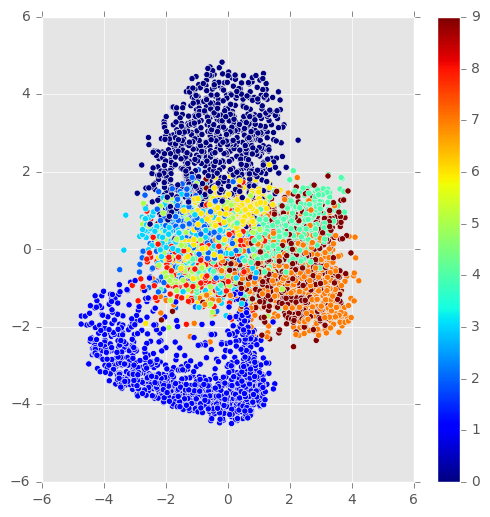

In [9]:
# ===== plotting encoder output
# display a 2D plot of the digit classes in the latent space
reload(plotstuff)
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
print(x_test_encoded.shape)
# plotstuff.Easy3dScatter(plt, x_test_encoded, '', s=10, c=y_test )

plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

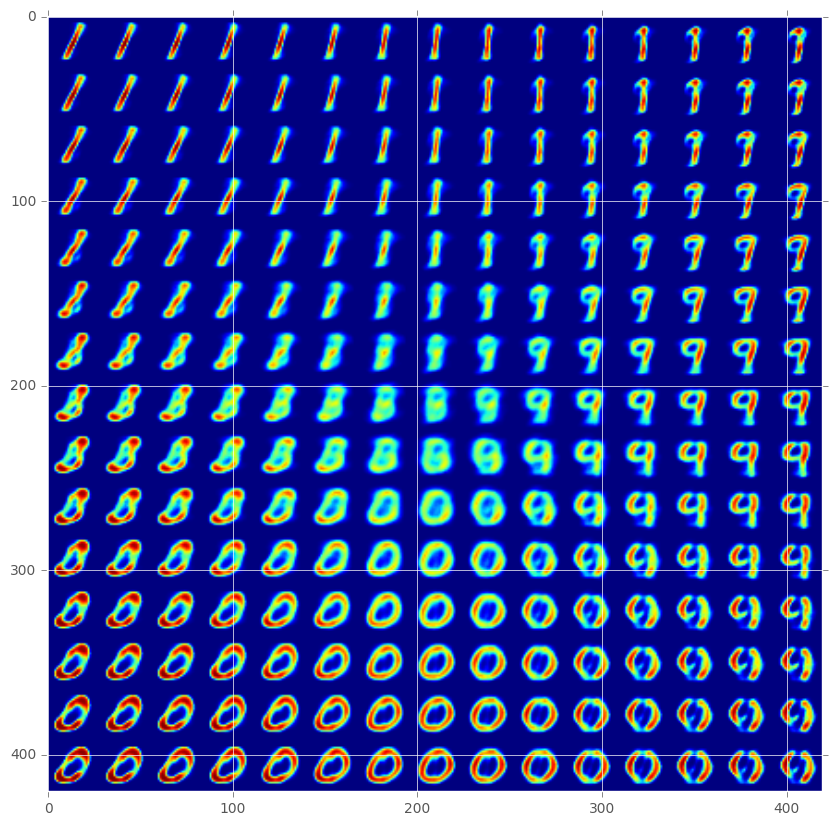

In [10]:
# ====== plotting decoder from latent space =======
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
ss=4
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# we will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-ss, ss, n)
grid_y = np.linspace(-ss, ss, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()

# Test some digits

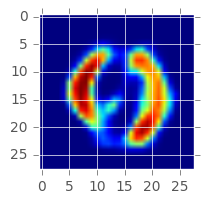

In [11]:
def draw_digit(z_sample, digit_size = 28, n=1):
    z_sample = np.array(z_sample).reshape(1,2)
    figure = np.zeros((digit_size * n, digit_size * n))
    x_decoded = generator.predict(z_sample)
    digit = x_decoded[0].reshape(digit_size, digit_size)
    i, j = 0,0
    figure[i * digit_size: (i + 1) * digit_size,
           j * digit_size: (j + 1) * digit_size] = digit
    plt.figure(figsize=(2, 2))
    plt.imshow(figure)
    plt.show()
    
draw_digit((4,4))

In [14]:
assert 0, 'halt'

AssertionError: halt

In [13]:
# build a digit generator that can sample from the learned distribution
latent_dim = 2
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# we will sample n points within [-15, 15] standard deviations
ss = 3
grid_x = np.linspace(-ss, ss, n)
grid_y = np.linspace(-ss, ss, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()

NameError: name 'decoder_h' is not defined

# Convo VAE

In [14]:

class ConvoVAE(object):
    '''This script demonstrates how to build a variational autoencoder
    with Keras and deconvolution layers.

    Reference: "Auto-Encoding Variational Bayes" https://arxiv.org/abs/1312.6114
    '''
    def __init__(self, input_shape=(28,28,1), latent_dim=2, intermediate_dim=256, batch_size=100, epsilon_std=1.0, dropout_p=0.1,
                sigma=0.2):
        # input image dimensions
        self.input_shape = input_shape
        if len(input_shape) == 3:
            self.img_rows, self.img_cols, self.img_chns = input_shape
        elif len(input_shape) == 2:
            self.img_rows, self.img_cols = input_shape
            self.img_chns = 1
        else:
            raise IndexError("Invalid shape: {}".format(input_shape))
        self.batch_size = batch_size
        self.original_dim = np.prod(input_shape)
        self.latent_dim = latent_dim
        self.intermediate_dim = intermediate_dim
        self.epsilon_std = epsilon_std
        n_pool = 2

        # number of convolutional filters to use
        nb_filters = 64
        # convolution kernel size
        nb_conv = 3

        batch_size = 100
        if K_backend.image_dim_ordering() == 'th':
            self.original_img_size = (self.img_chns, self.img_rows, self.img_cols)
        else:
            self.original_img_size = (self.img_rows, self.img_cols, self.img_chns)

        x = Input(batch_shape=(batch_size,) + self.original_img_size)
        x_a = GaussianNoise(sigma)(x)
        x_a = GaussianDropout(dropout_p)(x_a)

#         x_a = Activation('linear')(x)
        conv_1 = Convolution2D(self.img_chns, 2, 2, border_mode='same', activation='relu')(x_a)
        conv_2 = Convolution2D(nb_filters,    2, 2, border_mode='same', activation='relu', subsample=(2, 2))(conv_1)
        conv_3 = Convolution2D(nb_filters, nb_conv, nb_conv, border_mode='same', activation='relu', subsample=(1, 1))(conv_2)
        conv_3 = MaxPooling2D((n_pool, n_pool))(conv_3)
        for i in range(5):
            conv_3 = BatchNormalization()(conv_3)
            conv_3 = Dropout(dropout_p)(conv_3)
            conv_3 = Convolution2D(nb_filters, nb_conv, nb_conv, border_mode='same', activation='relu', subsample=(1, 1))(conv_3)
        
      
        conv_3 = BatchNormalization()(conv_3)
        conv_4 = Convolution2D(nb_filters, nb_conv, nb_conv, border_mode='same', activation='relu', subsample=(1, 1))(conv_3)
        flat = Flatten()(conv_4)
        hidden = Dense(intermediate_dim, activation='relu')(flat)

        self.z_mean = Dense(latent_dim)(hidden)
        self.z_log_var = Dense(latent_dim)(hidden)

        # note that "output_shape" isn't necessary with the TensorFlow backend
        # so you could write `Lambda(sampling)([z_mean, z_log_var])`
        z = Lambda(self.sampling, output_shape=(latent_dim,))([self.z_mean, self.z_log_var])

        # we instantiate these layers separately so as to reuse them later
        decoder_hid = Dense(intermediate_dim, activation='relu')
        decoder_upsample = Dense(nb_filters * 14 * 14, activation='relu')

        if K_backend.image_dim_ordering() == 'th':
            output_shape = (batch_size, nb_filters, 14, 14)
        else:
            output_shape = (batch_size, 14, 14, nb_filters)

        decoder_reshape = Reshape(output_shape[1:])
        decoder_deconv_1 = Deconvolution2D(nb_filters, nb_conv, nb_conv, output_shape,
                                           border_mode='same', subsample=(1, 1), activation='relu')
        decoder_deconv_2 = Deconvolution2D(nb_filters, nb_conv, nb_conv, output_shape,
                                           border_mode='same', subsample=(1, 1),activation='relu')
        if K_backend.image_dim_ordering() == 'th':
            output_shape = (batch_size, nb_filters, 29, 29)
        else:
            output_shape = (batch_size, 29, 29, nb_filters)
        decoder_deconv_3_upsamp = Deconvolution2D(nb_filters, 2, 2, output_shape,
                                                  border_mode='valid', subsample=(2, 2), activation='relu')
        decoder_mean_squash = Convolution2D(self.img_chns, 2, 2, border_mode='valid', activation='sigmoid')

        hid_decoded = decoder_hid(z)
        up_decoded = decoder_upsample(hid_decoded)
        reshape_decoded = decoder_reshape(up_decoded)
        deconv_1_decoded = decoder_deconv_1(reshape_decoded)
        deconv_2_decoded = decoder_deconv_2(deconv_1_decoded)
        x_decoded_relu = decoder_deconv_3_upsamp(deconv_2_decoded)
        x_decoded_mean_squash = decoder_mean_squash(x_decoded_relu)

        self.model = Model(x, x_decoded_mean_squash)
        self.model.compile(optimizer='rmsprop', loss=self.vae_loss)
        # self.model.summary()

        # build a model to project inputs on the latent space
        self.encoder = Model(x, self.z_mean)

        # build a digit generator that can sample from the learned distribution
        # todo: (un)roll this
        decoder_input = Input(shape=(latent_dim,))
        _hid_decoded = decoder_hid(decoder_input)
        _up_decoded = decoder_upsample(_hid_decoded)
        _reshape_decoded = decoder_reshape(_up_decoded)
        _deconv_1_decoded = decoder_deconv_1(_reshape_decoded)
        _deconv_2_decoded = decoder_deconv_2(_deconv_1_decoded)
        _x_decoded_relu = decoder_deconv_3_upsamp(_deconv_2_decoded)
        _x_decoded_mean_squash = decoder_mean_squash(_x_decoded_relu)
        self.generator = Model(decoder_input, _x_decoded_mean_squash)

    def sampling(self, args):
        z_mean, z_log_var = args
        epsilon = K_backend.random_normal(shape=(self.batch_size, self.latent_dim),
                                  mean=0., std=self.epsilon_std)
        return z_mean + K_backend.exp(z_log_var) * epsilon

    def vae_loss(self, x, x_decoded_mean):
        # NOTE: binary_crossentropy expects a batch_size by dim
        # for x and x_decoded_mean, so we MUST flatten these!
        x = K_backend.flatten(x)
        x_decoded_mean = K_backend.flatten(x_decoded_mean)
        xent_loss = self.img_rows * self.img_cols * objectives.binary_crossentropy(x, x_decoded_mean)
        kl_loss = - 0.5 * K_backend.mean(1 + self.z_log_var - K_backend.square(self.z_mean) - K_backend.exp(self.z_log_var), axis=-1)
        return xent_loss + kl_loss

    def fit(self, x, y, batch_size=None, nb_epoch=10, verbose=1, callbacks=[], validation_split=0.,
            validation_data=None, shuffle=True, class_weight=None, sample_weight=None):
        callbacks_history = self.model.fit(x, y, batch_size, nb_epoch, verbose, callbacks, validation_split,
                                           validation_data, shuffle, class_weight, sample_weight)
        return callbacks_history

In [15]:
    
vaeclass = ConvoVAE(latent_dim=2)
vae = vaeclass.model
encoder = vaeclass.encoder
generator = vaeclass.generator

In [16]:
# vae.summary()

In [17]:
keras.utils.visualize_util.plot(vae, 'vaec.png', show_shapes=True)
plt.show()

In [18]:
# train the VAE on MNIST digits
original_img_size = vaeclass.original_img_size
(x_train, _), (x_test, y_test) = mnist.load_data()

print(original_img_size)
x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape((x_train.shape[0],) + original_img_size)
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape((x_test.shape[0],) + original_img_size)


(28, 28, 1)


In [19]:
vae.fit(x_train, x_train,
        shuffle=True,
        nb_epoch=1,
        batch_size=batch_size,
        validation_data=(x_test, x_test),
        verbose=False, callbacks=[TQDMNotebookCallback()])


In [20]:
# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
print(x_test_encoded.shape)

(10000, 2)


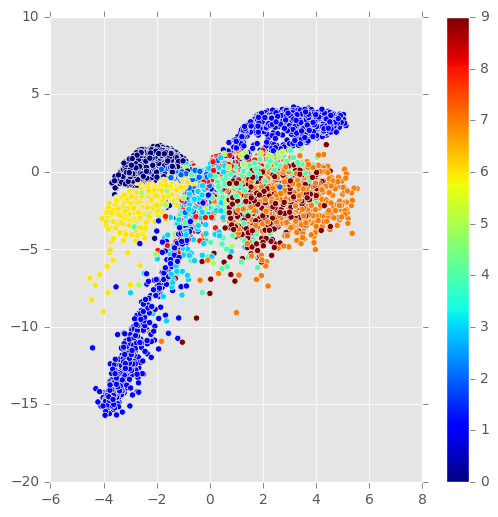

In [21]:
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

In [22]:
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plotstuff.Easy3dScatter(plt, x_test_encoded, '', s=10, c=y_test )

IndexError: index 2 is out of bounds for axis 1 with size 2

In [23]:
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
ss = 4
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# we will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-ss, ss, n)
grid_y = np.linspace(-ss, ss, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = generator.predict(z_sample, batch_size=batch_size)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

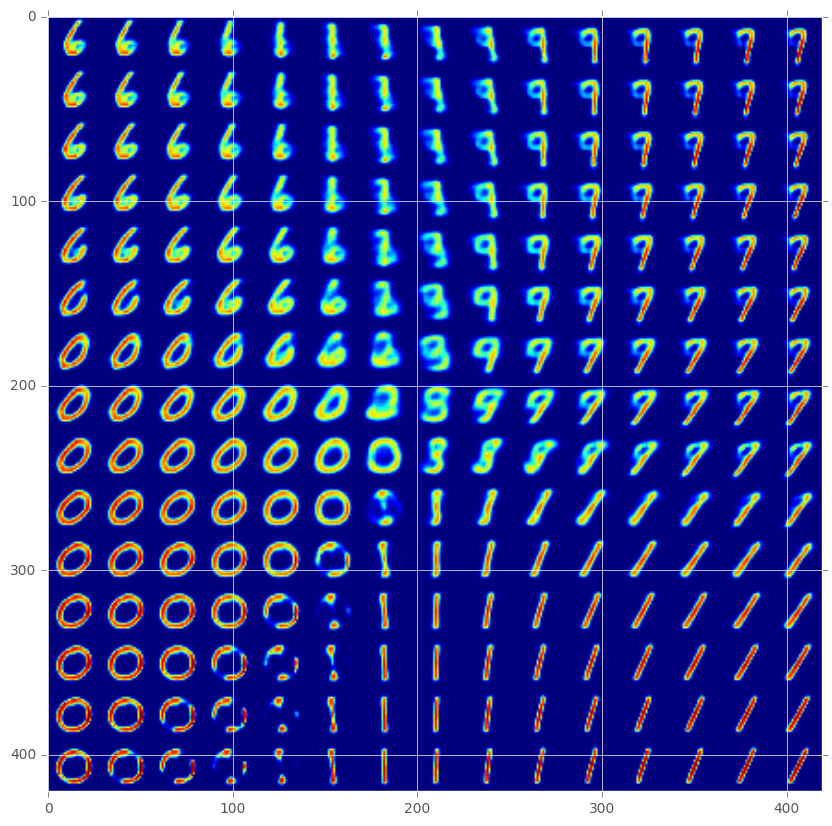

In [24]:
plt.figure(figsize=(10, 10))
plt.imshow(figure, origin='upper')
wid = n*digit_size
# plt.scatter(x_test_encoded[:, 0]*wid/4 + wid//2, x_test_encoded[:, 1]*wid/4 + wid//2, c=y_test, alpha=0.5)

plt.show()

# Crossfire

In [25]:
class Crossfire(object):
    """
    Covolutional VAE with a "crossfire" component - a classifier is bolted onto the end of the encoder and loss function
    can be parameterized to function from classifier loss instead of autoencoder loss. Ideally, the model starts in
    pure autoencoder mode to learn features, then as loss flattens out the network starts weighing classifier loss
    more heavily.
    Note to self: things to try:
    * Add burst /batch / epoch noise to input
    * Modularize out the activation from dropout ordering"""

    def __init__(self, input_shape=(28, 28, 1), latent_dim=2, intermediate_dim=256, batch_size=100, epsilon_std=1.0,
                 dropout_p=0.1, n_stax=0, n_classes=10):
        # input image dimensions
        self.input_shape = input_shape
        if len(input_shape) == 3:
            self.img_rows, self.img_cols, self.img_chns = input_shape
        elif len(input_shape) == 2:
            self.img_rows, self.img_cols = input_shape
            self.img_chns = 1
        else:
            raise IndexError("Invalid shape: {}".format(input_shape))
        self.batch_size = batch_size
        self.original_dim = np.prod(input_shape)
        self.latent_dim = latent_dim
        self.intermediate_dim = intermediate_dim
        self.epsilon_std = epsilon_std
        self.epsilon_ce = 1.0e-9

        # number of convolutional filters to use
        nb_filters = 64
        # convolution kernel size
        nb_conv = 3

        batch_size = 100
        if K_backend.image_dim_ordering() == 'th':
            self.original_img_size = (self.img_chns, self.img_rows, self.img_cols)
        else:
            self.original_img_size = (self.img_rows, self.img_cols, self.img_chns)

        x = Input(batch_shape=(batch_size,) + self.original_img_size, name='main_input')
        conv_1 = Convolution2D(self.img_chns, 2, 2, border_mode='same', activation='relu')(x)
        conv_2 = Convolution2D(nb_filters, 2, 2,
                               border_mode='same', activation='relu', subsample=(2, 2))(conv_1)
        conv_3 = Convolution2D(nb_filters, nb_conv, nb_conv, border_mode='same', activation='relu', subsample=(1, 1))(
            conv_2)
        for i in range(n_stax):
            conv_3 = BatchNormalization()(conv_3)
            conv_3 = Dropout(dropout_p)(conv_3)
            conv_3 = Convolution2D(nb_filters, nb_conv, nb_conv, border_mode='same', activation='relu',
                                   subsample=(1, 1))(conv_3)

        conv_3 = BatchNormalization()(conv_3)
        conv_4 = Convolution2D(nb_filters, nb_conv, nb_conv, border_mode='same', activation='relu', subsample=(1, 1))(
            conv_3)
        flat = Flatten()(conv_4)
        hidden = Dense(intermediate_dim, activation='relu', name='intermed')(flat)

        self.z_mean = Dense(latent_dim, name='z_mean')(hidden)
        self.z_log_var = Dense(latent_dim, name='z_log_var')(hidden)


        # note that "output_shape" isn't necessary with the TensorFlow backend
        # so you could write `Lambda(sampling)([z_mean, z_log_var])`
        z = Lambda(self.sampling, output_shape=(latent_dim,))([self.z_mean, self.z_log_var])

        ## ==== End of encoding portion ======

        ## ==== Crossfire classifier =========
#         c = Lambda(self.crosser, output_shape=(latent_dim,))(self.z_mean, self.z_log_var)
        classer = Dense(n_classes, init='normal', activation='softmax', name='classer')(self.z_mean)

        # Slicer example
        # y = Lambda(lambda x: x[:,0,:,:], output_shape=(1,) + input_shape[2:])(x)




        # we instantiate these layers separately so as to reuse them later
        decoder_hid = Dense(intermediate_dim, activation='relu')
        decoder_upsample = Dense(nb_filters * 14 * 14, activation='relu')

        if K_backend.image_dim_ordering() == 'th':
            output_shape = (batch_size, nb_filters, 14, 14)
        else:
            output_shape = (batch_size, 14, 14, nb_filters)

        decoder_reshape = Reshape(output_shape[1:])
        decoder_deconv_1 = Deconvolution2D(nb_filters, nb_conv, nb_conv, output_shape, border_mode='same', subsample=(1, 1), activation='relu')
        decoder_deconv_2 = Deconvolution2D(nb_filters, nb_conv, nb_conv, output_shape, border_mode='same', subsample=(1, 1), activation='relu')
        if K_backend.image_dim_ordering() == 'th':
            output_shape = (batch_size, nb_filters, 29, 29)
        else:
            output_shape = (batch_size, 29, 29, nb_filters)
        decoder_deconv_3_upsamp = Deconvolution2D(nb_filters, 2, 2, output_shape,
                                                  border_mode='valid', subsample=(2, 2), activation='relu')
        decoder_mean_squash = Convolution2D(self.img_chns, 2, 2, border_mode='valid', 
                                            activation='sigmoid', name='main_output')

        hid_decoded = decoder_hid(z)
        up_decoded = decoder_upsample(hid_decoded)
        reshape_decoded = decoder_reshape(up_decoded)
        deconv_1_decoded = decoder_deconv_1(reshape_decoded)
        deconv_2_decoded = decoder_deconv_2(deconv_1_decoded)
        x_decoded_relu = decoder_deconv_3_upsamp(deconv_2_decoded)
        x_decoded_mean_squash = decoder_mean_squash(x_decoded_relu)

        

        # build a digit generator that can sample from the learned distribution
        # todo: (un)roll this
        decoder_input = Input(shape=(latent_dim,))
        _hid_decoded = decoder_hid(decoder_input)
        _up_decoded = decoder_upsample(_hid_decoded)
        _reshape_decoded = decoder_reshape(_up_decoded)
        _deconv_1_decoded = decoder_deconv_1(_reshape_decoded)
        _deconv_2_decoded = decoder_deconv_2(_deconv_1_decoded)
        _x_decoded_relu = decoder_deconv_3_upsamp(_deconv_2_decoded)
        _x_decoded_mean_squash = decoder_mean_squash(_x_decoded_relu)
        

        
        # Generate models
        # Primary model - VAE
        self.model = Model(x, x_decoded_mean_squash)
        # Crossfilre network
        self.classifier = Model(x, classer)
        # Ok, now comes the tricky part. See these references:
        # https://keras.io/getting-started/functional-api-guide/#multi-input-and-multi-output-models
        self.crossmodel = Model(input=x, output=[x_decoded_mean_squash, classer])
        self.crossmodel.compile(optimizer='rmsprop',
                               loss={'main_output': self.vae_loss,
                                    'classer': 'categorical_crossentropy'},
                               loss_weights={'main_output': 1.0,
                                            'classer': 5.0})
        
        # build a model to project inputs on the latent space
        self.encoder = Model(x, self.z_mean)
        # reconstruct digits from latent space        
        self.generator = Model(decoder_input, _x_decoded_mean_squash)
        self.model.compile(optimizer='rmsprop', loss=self.vae_loss)
        self.classifier.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#         self.classifier.compile(loss=self.custom_crossent, optimizer='adam', metrics=['accuracy'])

        
    def fit_crossmodel(self, x_dict, y_dict, batch_size=None, nb_epoch=10, verbose=1, callbacks=[], validation_split=0.,
            validation_data=None, shuffle=True, class_weight=None, sample_weight=None):
        callbacks_history = self.crossmodel.fit(x_dict, y_dict, batch_size, nb_epoch, verbose, callbacks, validation_split,
                                           validation_data, shuffle, class_weight, sample_weight)
        return callbacks_history

    def sampling(self, args):
        z_mean, z_log_var = args
        epsilon = K_backend.random_normal(shape=(self.batch_size, self.latent_dim),
                                          mean=0., std=self.epsilon_std)
        return z_mean + K_backend.exp(z_log_var) * epsilon
    
    def crosser(self, args):
        z_mean, z_log_var = args
        return z_mean

    def vae_loss(self, x, x_decoded_mean):
        # NOTE: binary_crossentropy expects a batch_size by dim
        # for x and x_decoded_mean, so we MUST flatten these!
        x = K_backend.flatten(x)
        x_decoded_mean = K_backend.flatten(x_decoded_mean)
        xent_loss = self.img_rows * self.img_cols * objectives.binary_crossentropy(x, x_decoded_mean)
        kl_loss = - 0.5 * K_backend.mean(1 + self.z_log_var - K_backend.square(self.z_mean) - K_backend.exp(self.z_log_var), axis=-1)
        return xent_loss + kl_loss
    
    def custom_crossent(self, y_true, y_pred):
        '''Just another crossentropy'''
        
#         y_pred = K_backend.clip(y_pred, self.epsilon_ce, 1.0 - self.epsilon_ce)
#         y_pred /= K_backend.sum(y_pred, axis=-1, keepdims=True)
        cce = K_backend.categorical_crossentropy(y_pred, y_true)
        return cce
    
    

    def fit(self, x, y, batch_size=None, nb_epoch=10, verbose=1, callbacks=[], validation_split=0.,
            validation_data=None, shuffle=True, class_weight=None, sample_weight=None):
        callbacks_history = self.model.fit(x, y, batch_size, nb_epoch, verbose, callbacks, validation_split,
                                           validation_data, shuffle, class_weight, sample_weight)
        return callbacks_history

    def fit_ae(self, x, batch_size=None, nb_epoch=10, verbose=1, callbacks=[], validation_split=0.,
            validation_data=None, shuffle=True, class_weight=None, sample_weight=None):
        callbacks_history = self.model.fit(x, x, batch_size, nb_epoch, verbose, callbacks, validation_split,
                                           validation_data, shuffle, class_weight, sample_weight)
        return callbacks_history
    
    def crossfit(self, x, y, batch_size=None, nb_epoch_ae=5, nb_epoch_cf=10, verbose=1, callbacks=[], validation_split=0.,
            validation_data=None, shuffle=True, class_weight=None, sample_weight=None):
        valid_ae, valid_cf = validation_data
        for i in range(nb_epoch_ae):
            callbacks_history = self.model.fit(x, x, batch_size, 1, verbose, callbacks, validation_split,
                                           valid_ae, shuffle, class_weight, sample_weight)
        for i in range(nb_epoch_cf):
            callbacks_history = self.classifier.fit(x, y, batch_size, 1, verbose, callbacks, validation_split,
                                           valid_cf, shuffle, class_weight, sample_weight)
        return callbacks_history

In [38]:
latent_dim = 2
vaeclass = Crossfire(latent_dim=latent_dim, n_stax=3)
vae = vaeclass.model
encoder = vaeclass.encoder
generator = vaeclass.generator
classifier = vaeclass.classifier
crosser = vaeclass.crossmodel

In [39]:
# vae.summary()

In [40]:
import keras.utils.visualize_util
keras.utils.visualize_util.plot(vae, 'vaex.png', show_shapes=True)
keras.utils.visualize_util.plot(crosser, 'vaex_cross.png', show_shapes=True)
keras.utils.visualize_util.plot(classifier, 'vaex_cls.png', show_shapes=True)

# plt.show()


In [41]:
# train the VAE on MNIST digits
original_img_size = vaeclass.original_img_size
(x_train, y_train), (x_test, y_test) = mnist.load_data()
batch_size = 100
print(original_img_size)
x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape((x_train.shape[0],) + original_img_size)
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape((x_test.shape[0],) + original_img_size)

(28, 28, 1)


In [42]:
# one hot encode outputs
y_train_oh = np_utils.to_categorical(y_train)
y_test_oh = np_utils.to_categorical(y_test)
num_classes = y_test_oh.shape[1]
print(y_train.shape, y_test_oh.shape)
print('x_train.shape:', x_train.shape)
print('x_train.shape:', x_train.shape)

(60000,) (10000, 10)
x_train.shape: (60000, 28, 28, 1)
x_train.shape: (60000, 28, 28, 1)


### Important note: it looks like the model should be trained 1 epoch on VAE only, then 5ish on mixed, and then the remainder on classifier

In [43]:
print('shapes: ', x_train.shape, x_test.shape)
vae.fit(x_train, x_train,
        shuffle=True,
        nb_epoch=1,
        batch_size=batch_size,
        validation_data=(x_test, x_test),
        verbose=False, callbacks=[TQDMNotebookCallback()])



shapes:  (60000, 28, 28, 1) (10000, 28, 28, 1)



In [44]:
vaeclass.fit_crossmodel(x_train, {'main_output': x_train, 'classer': y_train_oh}, 
        shuffle=True, batch_size=100, validation_data=(x_test, {'main_output':x_test, 'classer':y_test_oh}), 
        nb_epoch=5,
        verbose=False, callbacks=[TQDMNotebookCallback()])

In [45]:
# vaeclass.crossfit(x_train, y_train_oh, shuffle=True, batch_size=100, validation_data=((x_test, x_test), (x_test, y_test_oh)), 
#         nb_epoch_ae=1, nb_epoch_cf=1)

In [46]:
classifier.fit(x_train, 
               y_train_oh, 
               shuffle=True,
               batch_size=100, 
               validation_data=(x_test, y_test_oh), 
               nb_epoch=5,
               verbose=False, callbacks=[TQDMNotebookCallback()])


In [47]:
# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
print(x_test_encoded.shape)

(10000, 2)


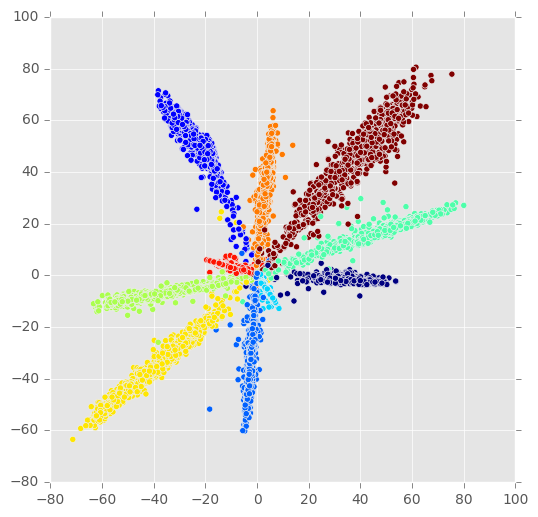

In [48]:
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.show()

In [49]:
x_train_encoded = encoder.predict(x_train, batch_size=batch_size)
print(x_train_encoded.shape)

(60000, 2)


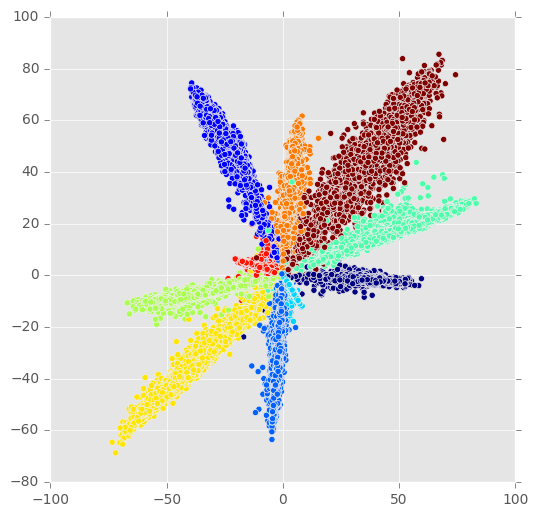

In [50]:
plt.figure(figsize=(6, 6))
plt.scatter(x_train_encoded[:, 0], x_train_encoded[:, 1], c=y_train)
plt.show()

In [ ]:
plotstuff.Easy3dScatter(plt, x_test_encoded[:,:3], '', s=10, c=y_test )


In [ ]:
x_train_pred = classifier.predict(x_train, batch_size=batch_size)
x_test_pred = classifier.predict(x_test, batch_size=batch_size)

In [ ]:
plt.plot(np.std(x_test_pred, axis=1))

In [ ]:
plt.plot(x_train_pred[0])

In [ ]:
ambig = np.sum(np.greater(x_train_pred, 0.5) == y_train_oh, axis=1)

In [ ]:
np.mean(ambig)

In [ ]:
score = classifier.evaluate(x_test, y_test_oh, batch_size=batch_size )

In [ ]:
score

In [ ]:
ambig = np.where(np.std(x_train_pred, axis=1) < 0.18)
ambig

In [ ]:
n = 8853
print(y_train[n], np.argmax(x_train_pred[n]))
print(np.round(x_train_pred[n]*1000))
plt.imshow(x_train[n].reshape(28,28))